# 📊 Exploratory Data Analysis for Predictive Association Rule Mining
## Introduction

This notebook presents the exploratory data analysis (EDA) of the Instacart Online Grocery Basket dataset. The dataset contains millions of grocery transactions describing customer orders, product details, and purchasing behavior over time.

The objective of this project is not only to discover product associations, but to evaluate whether these associations can realistically predict future customer purchases and generate measurable business value (e.g., improved bundling strategies, targeted promotions, and revenue optimization).

![Data Science Project Process](images/download.svg)

Because the data is sequential, special attention must be given to:

* Order chronology

* Reordering behavior

* Basket structure

* Potential data leakage

This exploratory phase aims to:

1. Validate the integrity and relationships of the dataset.

2. Analyze customer and basket behavior patterns.

3. Study product frequency distribution and long-tail effects.

4. Prepare a leakage-free train/test strategy for predictive association rule mining.

By the end of this notebook, we establish a robust foundation for applying association rule algorithms in a predictive and business-realistic setting.

### Step 0 — Load data + quick sanity check

__Goal:__ make sure we have the right columns + sizes + no obvious corruption.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# notebook is in: project_root/notebooks
PROJECT_ROOT = os.path.abspath("..")

INTERIM_DIR = os.path.join(PROJECT_ROOT, "data", "interim")
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")

os.makedirs(PROCESSED_DIR, exist_ok=True)

orders = pd.read_parquet(os.path.join(INTERIM_DIR, "orders.parquet"))
op = pd.read_parquet(os.path.join(INTERIM_DIR, "order_products.parquet"))
products = pd.read_parquet(os.path.join(INTERIM_DIR, "products.parquet"))
aisles = pd.read_parquet(os.path.join(INTERIM_DIR, "aisles.parquet"))
departments = pd.read_parquet(os.path.join(INTERIM_DIR, "departments.parquet"))


print("Loaded interim data ⏳")
print("orders_df:", orders.shape)
print("order_products_df:", op.shape)
print("products_df:", products.shape)
print("aisles_df:", aisles.shape)
print("departments_df:", departments.shape)
print("✅ All interim data loaded successfully")
# The head of orders dataset
print(orders.head())
" The head of order_products dataset"
print(op.head())    

Loaded interim data ⏳
orders_df: (3421083, 7)
order_products_df: (33819106, 4)
products_df: (49688, 4)
aisles_df: (134, 2)
departments_df: (21, 2)
✅ All interim data loaded successfully
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        93

__What we conclude__: 
dataset scale, confirm key fields exist:

orders: `order_id`, `user_id`, `order_number`, `days_since_prior_order`

order products: `order_id`, `product_id`, `add_to_cart_order`, `reordered`

### Step 01: Check uniqueness + keys (data quality)

Goal: Ensure joins won't duplicate or lose data

In [24]:
# Uniqueness checks
assert orders["order_id"].is_unique, "orders.order_id should be unique"
assert products["product_id"].is_unique, "products.product_id should be unique"
assert aisles["aisle_id"].is_unique, "aisles.aisle_id should be unique"
assert departments["department_id"].is_unique, "departments.department_id should be unique"

# Null checks
print("orders nulls:")
print(orders.isna().mean().sort_values(ascending=False).head(10))
print("\norder_products nulls:")
print(op.isna().mean().sort_values(ascending=False).head(10))

orders nulls:
days_since_prior_order    0.060276
user_id                   0.000000
order_id                  0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
dtype: float64

order_products nulls:
order_id             0.0
product_id           0.0
add_to_cart_order    0.0
reordered            0.0
dtype: float64


__What we conclude:__

`days_since_prior_order` is expected to be null for first orders.

Other IDs should not be null.

### Step 02: Understand the entity relationships (the “aisle ↔ department” confusion)

__Reality:__ Instacart structure is:

* `products` → has `aisle_id` and `department_id`

* `aisles` → describes `aisle_id`

* `departments` → describes `department_id`

So __aisles don’t map 1-to-1 to departments globally__; many products in an aisle can belong to one department, but the safest truth is: __the product is the bridge.__

Check it:

In [25]:
prod_enriched = products.merge(aisles, on="aisle_id", how="left") \
                        .merge(departments, on="department_id", how="left")

# Are there aisles with multiple departments (via products)?
aisle_dept_counts = prod_enriched.groupby("aisle_id")["department_id"].nunique().sort_values(ascending=False)
aisle_dept_counts.head(10)

aisle_id
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
Name: department_id, dtype: int64

__What we conclude:__

If `nunique()` > 1 for some aisles, we must not force an aisle→department mapping directly, or we'll lose products / mislabel.

### Step 3 — Join orders + items + products and do a “sanity completeness check”

__Goal:__ after joining, ensure no order lines got dropped.

In [26]:
op0 = op.shape[0]

df = op.merge(orders, on="order_id", how="left")
assert df["user_id"].isna().sum() == 0, "Some order_id in op not found in orders!"

df = df.merge(products[["product_id","aisle_id","department_id"]], on="product_id", how="left")
assert df["aisle_id"].isna().sum() == 0, "Some product_id in op not found in products!"
assert df.shape[0] == op0, "Join changed number of rows (duplication or loss)!"

df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,86,16
1,2,28985,2,1,202279,prior,3,5,9,8.0,83,4
2,2,9327,3,0,202279,prior,3,5,9,8.0,104,13
3,2,45918,4,1,202279,prior,3,5,9,8.0,19,13
4,2,30035,5,0,202279,prior,3,5,9,8.0,17,13


__What to conclude:__

* We didn’t lose any order-product rows.

* We can trust this table for EDA + modeling.

### Step 4 —  🎯 Customer Behavioral Analysis: (time & repetition)

We want to understand:

1. How often customers order

2. How large their baskets are

3. How frequently they reorder products

4. Whether behavior is stable or highly variable

5. Whether segmentation makes sense

We’ll compute user-level features.

#### 4A) Orders per user

In [27]:
user_orders = orders.groupby("user_id")["order_number"].max()
user_orders.describe(percentiles=[.5,.75,.9,.95,.99])

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
50%          10.000000
75%          20.000000
90%          38.000000
95%          52.000000
99%          89.000000
max         100.000000
Name: order_number, dtype: float64

__📌 Interpretation:__

* Median tells us typical loyalty.

* High 95th percentile shows power users.

* If many users have 1 order → cold start problem.

__Conclude:__

Do we have enough repeat history?

If many users have only 1–2 orders, predictive evaluation becomes tricky (cold start).

#### 4B) Time gaps

In [28]:
orders["days_since_prior_order"].describe()
orders["days_since_prior_order"].value_counts(dropna=False).head(10)

days_since_prior_order
30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
NaN     206209
2.0     193206
8.0     181717
1.0     145247
Name: count, dtype: int64

__Conclude:__

* Shopping frequency patterns (weekly-ish, etc.)

* First orders have NaN gaps (normal)

### Step 5 — Basket characteristics (how baskets look)
#### 5A) Basket size distribution (items per order)

count    3.346083e+06
mean     1.010707e+01
std      7.542326e+00
min      1.000000e+00
50%      8.000000e+00
75%      1.400000e+01
90%      2.000000e+01
95%      2.500000e+01
99%      3.500000e+01
max      1.450000e+02
Name: product_id, dtype: float64


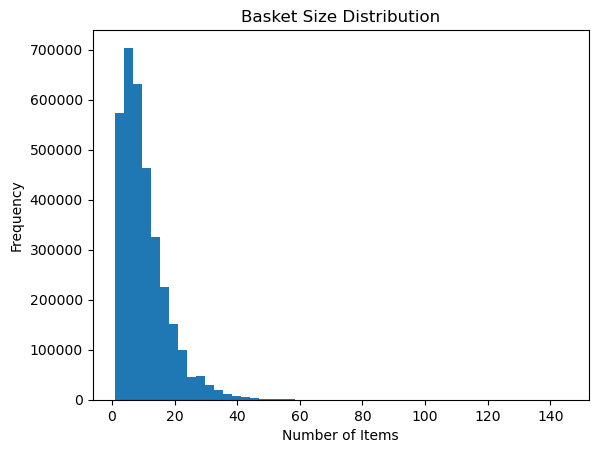

In [40]:
basket_size = op.groupby("order_id")["product_id"].count()
print(basket_size.describe(percentiles=[0.5,0.75,0.9,0.95,0.99]))

plt.figure()
plt.hist(basket_size, bins=50)
plt.title("Basket Size Distribution")
plt.xlabel("Number of Items")
plt.ylabel("Frequency")
plt.show()

__📌 Interpretation:__

* __Is basket size consistent?__

Mostly consistent within a core range, but not consistent overall.

_Why:_

The distribution is heavily right‑skewed. The tallest bars are at small basket sizes (roughly 3–10 items), and frequency drops quickly after ~15 items.
This means most orders cluster in a fairly tight band (small baskets), but there’s a long tail of larger orders.
Practically: you can rely on a typical basket being single‑digit to low‑teens items, but you should expect occasional bigger baskets.

* __Are there extreme outliers?__

Yes.

The plot shows a long tail extending to very large basket sizes (tens of items; visually some bins stretch beyond 50 and even further).
Past ~40–50+ items, counts are extremely sparse ⇒ rare events.
Treat these as outliers for modeling/UX unless you explicitly design for power users.

How to set an objective outlier rule (when you compute stats):

Tukey rule: outlier if size > Q3 + 1.5 × IQR.
High‑percentile rule: outlier if size > P99 (or P99.5).

Either approach will likely flag very large baskets (≈ 50+ items) as outliers in this dataset.

* __Helps define recommendation top-K size.__

Goal: show enough items to cover typical needs without overwhelming users.
A. Fixed K (simple, robust)

Choose K around the 80th–90th percentile of basket size.
From your plot (most mass under ~15 items), a sensible starting point is K = 8–12.

K = 5 works well in very constrained UI (mobile, in‑cart widget).
K = 10–12 is good for desktop or dedicated recommendation modules.


Cap the maximum K (e.g., 15) to avoid overloading the page.

B. Adaptive K (better UX)

Per user:
K_user = clip(round(P90(user’s past basket sizes)), 5, 15)
Per session / cart‑aware:
K_session = clip(2 + 0.5 × current_cart_size, 5, 15)
(more items when the user is building a bigger basket)

C. Training/metrics considerations

Exclude or down‑weight outliers (e.g., baskets > P99) during training or when tuning thresholds.
Retrieve more, re‑rank to top‑K (e.g., retrieve 50 candidates, re‑rank to top‑K) so model quality—not retrieval recall—limits what users see.

__Conclude:__

* Typical basket sizes

* Outliers (very large baskets)

* Helps choose evaluation metric and computational strategy.

#### Average Basket Size per User



#### 5B) Reorder rate

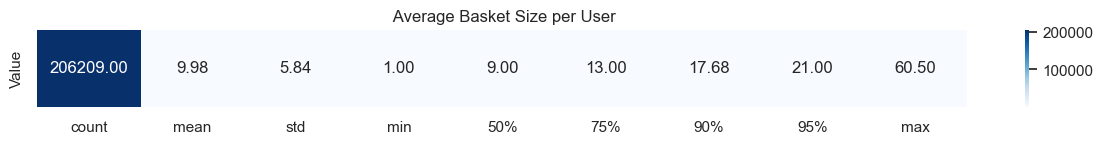

In [55]:
user_basket = op.groupby("order_id")["product_id"].count().reset_index()
user_basket = user_basket.merge(orders[["order_id","user_id"]], on="order_id")

avg_basket_user = user_basket.groupby("user_id")["product_id"].mean()

#print(avg_basket_user.describe(percentiles=[0.5,0.75,0.9,0.95]).to_frame("Value"))
sns.set_theme()
plt.figure(figsize=(15,1))
sns.heatmap(avg_basket_user.describe(percentiles=[0.5,0.75,0.9,0.95]).to_frame("Value").T, annot=True, fmt=".2f", cmap="Blues")
plt.title(" Average Basket Size per User")
plt.show()




__📌 Interpretation:__

* Some customers always buy small baskets

* Others are bulk buyers

* Useful for segmentation

__🔍 What this metric represents__

This summarizes the average number of items each user buys per order, giving insight into users’ overall shopping behavior rather than per‑order variability.
It answers questions like:

“How big are users’ typical baskets over time?”
“Are some users systematically heavy shoppers?”
“Is basket size stable across users?”


__📈 Central Tendency (Typical User Behavior)__

The median user averages 9 items per basket.
The mean is slightly higher (9.98), indicating the presence of some large‑basket users pulling the average upward.
This reflects a relatively stable “typical” basket size close to 9–10 items per order for most customers.


__📉 Variability Across Users__

Standard deviation = 5.84, which is quite large relative to the mean.
Interpretation: basket size varies significantly across users.

Some prefer small baskets (5–8 items).
Others regularly buy much larger baskets (15–20+ items).



This variability shows that Instacart has distinct user segments in terms of shopping behavior.

__🚨 Outliers & Heavy Users__

The 95th percentile is 21 items, meaning the top 5% of users regularly place very large orders.
The maximum average basket size (60.5 items) indicates the presence of extremely heavy or bulk shoppers with consistently large baskets.

These users have a strong influence on revenue and may require specific recommendation or retention strategies.

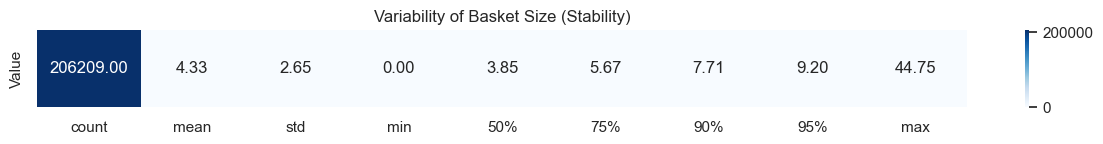

In [54]:
basket_per_user = user_basket.groupby("user_id")["product_id"]

basket_variability = basket_per_user.std()

#print(basket_variability.describe(percentiles=[0.5,0.75,0.9,0.95]).to_frame("Value"))

plt.figure(figsize=(15,1))
sns.heatmap(basket_variability.describe(percentiles=[0.5,0.75,0.9,0.95]).to_frame("Value").T, annot=True, fmt=".2f", cmap="Blues")
plt.title("Variability of Basket Size (Stability)")
plt.show()

__🔍 Distribution Shape & Skew__

The median (3.85) is slightly lower than the mean (4.33), indicating a right‑skewed distribution.
This means most baskets are small, but there is a long tail of larger baskets.
The majority of orders remain within a relatively narrow range (≈ 4–6 items).


__📈 Variability (Stability)__

Standard deviation = 2.65, which is moderate relative to the mean.
Coefficient of Variation ≈ 0.61, indicating moderate variability.
Interpretation: Even though basket sizes vary, they fluctuate within a stable and predictable range around ~4–5 items for most users.


__🚨 Outliers & Long Tail__

The maximum basket size (≈ 45 items) reveals rare but extreme outliers.
Such cases represent unusually large orders and should be:

Capped (e.g., at P95 or P99) when modeling, or
Down‑weighted to avoid skewing predictions.




#### Reorder Behavior

Reorder rate tells us how repetitive customers are.


#### 5B) Reorder rate

In [42]:
# Global reorder rate
print("Global reorder rate:", op["reordered"].mean())

# Per user reorder rate
user_reorder = op.merge(orders[["order_id","user_id"]], on="order_id")
user_reorder_rate = user_reorder.groupby("user_id")["reordered"].mean()

print(user_reorder_rate.describe(percentiles=[0.5,0.75,0.9,0.95]))

Global reorder rate: 0.5900617242809434
count    206209.000000
mean          0.444332
std           0.206270
min           0.000000
50%           0.442623
75%           0.601562
90%           0.723787
95%           0.781421
max           0.989637
Name: reordered, dtype: float64



#### Optional: Simple Customer Segmentation (KMeans)

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# Build a customer Feature Table for clustering
customer_features = pd.DataFrame({
    "num_orders": user_orders,
    "avg_basket_size": avg_basket_user,
    "reorder_rate": user_reorder_rate,
    "basket_variability": basket_variability
})

customer_features = customer_features.fillna(0)

customer_features.head()

X = customer_features.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
customer_features["segment"] = kmeans.fit_predict(X_scaled)

customer_features["segment"].value_counts()

c:\Users\i025423\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\i025423\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


segment
1    113644
0     51602
2     40963
Name: count, dtype: int64

In [57]:
customer_features.groupby("segment").mean()

,num_orders,avg_basket_size,reorder_rate,basket_variability
segment,,,,
0,12.422077,17.013412,0.438342,7.391722
1,9.410783,7.073510,0.356361,3.013983
2,41.759637,9.206144,0.695937,4.100012


##### __🟦 Segment 0 – Large-Basket, Medium-Frequency Shoppers__

* _Profile_

- Moderate number of orders (~12)
- Largest baskets on average (17 items)
- Medium reorder rate (~44%)
- Highest variability in basket size

__Interpretation__:

These are bulk shoppers or customers who stock up during fewer but larger trips.
Their behavior is less predictable due to high variability. They may mix big stock‑ups with small fill‑in trips.

__Business Actions__:

Recommend bundles, multi‑item promotions, or aisle‑level recommendations.
Trigger reminders less frequently, but with higher-value suggestions.
Personalize toward categories often included in large hauls (e.g., beverages, household goods).

##### 🟩 Segment 1 – Small-Basket, Low-Frequency Shoppers
*_Profile_

- Few orders (~9)
- Smallest baskets (~7 items)
- Lowest reorder rate (~35%)
- Most stable (low variability)

__Interpretation__:

These are light users, likely occasional shoppers or people using the service for quick top-ups.
Their shopping behavior is simpler, less repetitive, and less loyal to specific items.

__Business Actions__

Keep recommendations short and focused (small Top‑K).
Emphasize quick-pick lists, deals, and convenience items.
Marketing actions: re-engagement campaigns, first‑time buyer promotions, loyalty nudges.


##### 🟥 Segment 2 – Heavy Repeat Buyers (High-Frequency Regulars)
*_Profile_

- Very high order frequency (~42 orders)
- Medium-sized baskets (~9 items)
- Highest reorder rate (~70%)
- Moderate variability

__Interpretation__

These are power users: loyal, frequent, and predictable shoppers.
They reorder a large share of past items, indicating stable habits and strong platform engagement.

__Business Actions__

Optimize recommendations for reorder prediction (“Buy again”, personalized restock cycles).
Use high Top‑K since they browse more and shop more frequently.
Offer subscription-like programs, loyalty perks, or predictive ordering reminders.

In [31]:
op["reordered"].mean(), op["reordered"].value_counts(normalize=True)

(np.float64(0.5900617242809434),
 reordered
 1    0.590062
 0    0.409938
 Name: proportion, dtype: float64)

__📌 Interpretation:__

* High reorder rate → habit-driven shopping

* Good for predictive association rules

* Low reorder rate → exploratory customers

reorder once = 1 is 59% while orders without reorder is 41% 

__Conclude:__
* Instacart has strong repetition → good for next-basket prediction.

#### Shopping frequency (time between orders)




count    3.214874e+06
mean     1.111484e+01
std      9.206737e+00
min      0.000000e+00
50%      7.000000e+00
75%      1.500000e+01
90%      3.000000e+01
95%      3.000000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64


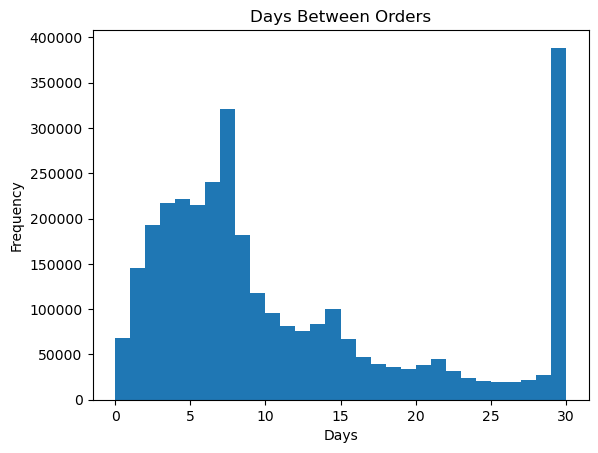

In [44]:
# Remove first orders (NaN)
freq = orders["days_since_prior_order"].dropna()

print(freq.describe(percentiles=[0.5,0.75,0.9,0.95]))

plt.figure()
plt.hist(freq, bins=30)
plt.title("Days Between Orders")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

__📌 Interpretation:__

Weekly shoppers dominate: The distribution peaks sharply around 6–7 days, showing a strong weekly cycle.
Some bi‑weekly shoppers: A noticeable, though smaller, portion reorder around 12–15 days, but there is no strong bi‑weekly peak.
Irregular shoppers: The long tail (15–30 days) indicates customers with inconsistent or sporadic shopping.
Spike at 30 days: Likely “max gap” values or infrequent buyers.


### Step 6 — Product frequency + long tail

__Goal:__ see if product purchases are extremely skewed (they usually are).

In [32]:
prod_freq = op["product_id"].value_counts()
prod_freq.describe(percentiles=[.5,.75,.9,.95,.99])

count     49685.000000
mean        680.670343
std        4987.769425
min           1.000000
50%          63.000000
75%         272.000000
90%        1066.000000
95%        2382.600000
99%       10375.800000
max      491291.000000
Name: count, dtype: float64

Optional: “coverage” curve (how many products explain X% of purchases):

In [33]:
cum = (prod_freq / prod_freq.sum()).cumsum()
cum[cum <= 0.5].shape[0], cum[cum <= 0.8].shape[0], cum[cum <= 0.9].shape[0]

(789, 4558, 9191)

__Conclude:__

If heavy long tail: rules will be dominated by frequent staples unless you filter or do category-level rules too.

### Step 7 — Temporal leakage check (the key “future can’t predict past” point)

Even before doing predictive AR, verify chronology is usable.

__For each user:__ last order number is their “future”.

In [34]:
orders_sorted = orders.sort_values(["user_id","order_number"])
last_order_per_user = orders_sorted.groupby("user_id").tail(1)[["user_id","order_id","order_number"]]
last_order_per_user.head()

,user_id,order_id,order_number
10,1,1187899,11
25,2,1492625,15
38,3,2774568,13
44,4,329954,6
49,5,2196797,5


__Conclude:__

You can create a per-user split: “all but last” vs “last”.

### Step 8 — Build “predictive-ready” datasets (without mining yet)

This step creates the train/test split correctly, but we still haven’t mined rules.

#### 8A) Train = orders before the last order (per user)
#### 8B) Test = last order (per user)

In [35]:
# Identify last order_id per user
last_orders = orders_sorted.groupby("user_id").tail(1)[["user_id","order_id"]].rename(columns={"order_id":"test_order_id"})

# Mark each order as train/test
orders_tagged = orders.merge(last_orders, on="user_id", how="left")
orders_tagged["is_test"] = orders_tagged["order_id"] == orders_tagged["test_order_id"]

train_orders = orders_tagged.loc[~orders_tagged["is_test"], "order_id"]
test_orders  = orders_tagged.loc[ orders_tagged["is_test"], "order_id"]

op_train = op[op["order_id"].isin(train_orders)]
op_test  = op[op["order_id"].isin(test_orders)]

op_train.shape, op_test.shape

((32434489, 4), (1384617, 4))

### Step 9 — “Small random chunk gives same results?” (EDA version)

Before mining rules, we check whether sampling is representative.

Sample 10–20% of train orders and compare basket size & top products.

In [36]:
import numpy as np

rng = np.random.default_rng(42)
train_order_ids = train_orders.values
sample_ids = rng.choice(train_order_ids, size=int(0.2 * len(train_order_ids)), replace=False)

op_train_sample = op_train[op_train["order_id"].isin(sample_ids)]

# Compare basket sizes
bs_full = op_train.groupby("order_id")["product_id"].count()
bs_samp = op_train_sample.groupby("order_id")["product_id"].count()

bs_full.describe(), bs_samp.describe()

(count    3.214874e+06
 mean     1.008888e+01
 std      7.525398e+00
 min      1.000000e+00
 25%      5.000000e+00
 50%      8.000000e+00
 75%      1.400000e+01
 max      1.450000e+02
 Name: product_id, dtype: float64,
 count    642974.000000
 mean         10.092781
 std           7.520747
 min           1.000000
 25%           5.000000
 50%           8.000000
 75%          14.000000
 max         145.000000
 Name: product_id, dtype: float64)

Compare top products overlap:

In [37]:
top_full = set(op_train["product_id"].value_counts().head(200).index)
top_samp = set(op_train_sample["product_id"].value_counts().head(200).index)

overlap = len(top_full & top_samp) / len(top_full)
overlap

0.985

__Conclude:__

If basket size stats and top-product overlap are close → sampling is safe for faster experiments.